In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import re

from tools import NodeLookup,show_images_diff

In [2]:
#加载解码的图像 这里是个大坑 tf提供的imagenet预训练好的模型pb文件中 包含针对图像的预处理环节 即解码jpg文件 这部分没有梯度
#需要直接处理解码后的数据
session=tf.Session()

target = tf.placeholder(tf.int32)


def create_graph(dirname):
    with tf.gfile.FastGFile(dirname, 'rb') as f:
        graph_def = session.graph_def
        graph_def.ParseFromString(f.read())

        _ = tf.import_graph_def(graph_def, name='')

#从'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'下载并解压到指定路径
create_graph("models/classify_image_graph_def.pb")

# 初始化参数  非常重要
session.run(tf.global_variables_initializer())
tensorlist=[n.name for n in session.graph_def.node]

#print(tensorlist)

#这里注意 一定要查看下当前tensor的名称再写 因为导入pb时指定了名称前缀adv
softmax_tensor = session.graph.get_tensor_by_name('softmax:0')
input_tensor=session.graph.get_tensor_by_name('ExpandDims:0')
logits_tensor=session.graph.get_tensor_by_name('softmax/logits:0')


In [3]:
imagename="../picture/horse.jpeg"

image=np.array(Image.open(imagename).convert('RGB').resize((100,100))).astype(np.float32)
#[100,100,3]->[1,100,100,3]
image=np.expand_dims(image, axis=0)

predictions = session.run(softmax_tensor,
                           {input_tensor: image})
predictions = np.squeeze(predictions)

# Creates node ID --> English string lookup.
node_lookup = NodeLookup()

#top 3
top_k = predictions.argsort()[-3:][::-1]
for node_id in top_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print('%s (score = %.5f)(id = %d)' % (human_string, score,node_id))

sorrel (score = 0.09500)(id = 39)
hartebeest (score = 0.08867)(id = 65)
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis (score = 0.07599)(id = 52)


In [4]:
#实现saliency_map
def saliency_map(derivative, mask):
        
        alphas = derivative * mask

        # pixel influence on sum of residual classes
        betas = -np.ones_like(alphas)
        
        sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
        # find optimal pixel & direction of perturbation
        idx = np.argmin(sal_map)
        
        #转换成(p1,p2)格式      
        idx = np.unravel_index(idx, mask.shape)
        pix_sign = np.sign(alphas)[idx]
    
        return idx, pix_sign

In [5]:

epochs=500
#扰动系数
theta=0.1
target_label=288

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_tensor, labels=[target])

#前向计算 这一过程非常缓慢
derivative, = tf.gradients(logits_tensor[0,target_label], input_tensor)

session.run(tf.global_variables_initializer())

adv_img=image.copy()

print(adv_img.shape)

node_lookup = NodeLookup()
# the mask defines the search domain
# each modified pixel with border value is set to zero in mask
mask = np.ones_like(adv_img)

#定义边界
max_=255
min_=0

for epoch in range(epochs):
    
    s,d,l=session.run([logits_tensor,derivative,loss],{target:target_label,input_tensor:adv_img})
    
    predictions = np.squeeze(s)

    top_k = predictions.argsort()[-3:][::-1]
    
    predictions_id=top_k[0]
    
    print("epoch={} loss={} label={}".format(epoch,l[0],predictions_id))
    
    if predictions_id == target_label:
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)(id = %d)' % (human_string, score,node_id))
        break
    
    idx, pix_sign=saliency_map(d, mask)
       
    # apply perturbation 
    adv_img[idx]+=pix_sign * theta * (max_ - min_) 
    
    #达到极限的点不再参与更新
    if (adv_img[idx]<=min_) or (adv_img[idx]>=max_):
        print("idx={} over {}".format(idx,adv_img[idx]))
        mask[idx]=0
        adv_img[idx]=np.clip(adv_img[idx], min_, max_)
    
     

(1, 100, 100, 3)
epoch=0 loss=7.979178428649902 label=39
epoch=1 loss=7.865482330322266 label=121
idx=(0, 75, 81, 1) over 280.5
epoch=2 loss=7.865482330322266 label=121
epoch=3 loss=7.823239326477051 label=121
idx=(0, 74, 81, 1) over 280.5
epoch=4 loss=7.823239326477051 label=121
idx=(0, 3, 8, 1) over 280.5
epoch=5 loss=7.823239803314209 label=121
idx=(0, 75, 81, 0) over 280.5
epoch=6 loss=7.823239326477051 label=121
idx=(0, 73, 79, 1) over 280.5
epoch=7 loss=7.823239326477051 label=121
idx=(0, 75, 81, 2) over 280.5
epoch=8 loss=7.823239326477051 label=121
idx=(0, 2, 8, 1) over 280.5
epoch=9 loss=7.823239326477051 label=121
epoch=10 loss=7.841790676116943 label=121
idx=(0, 74, 81, 2) over 280.5
epoch=11 loss=7.841790199279785 label=121
idx=(0, 76, 81, 1) over 280.5
epoch=12 loss=7.841790676116943 label=121
idx=(0, 74, 81, 0) over 280.5
epoch=13 loss=7.841790199279785 label=121
idx=(0, 2, 7, 1) over 280.5
epoch=14 loss=7.841790199279785 label=121
epoch=15 loss=7.7842793464660645 label=1

epoch=158 loss=5.4012770652771 label=121
epoch=159 loss=5.328059196472168 label=121
epoch=160 loss=5.269566059112549 label=46
epoch=161 loss=5.189125061035156 label=46
epoch=162 loss=5.143030166625977 label=46
epoch=163 loss=5.078320026397705 label=46
idx=(0, 62, 77, 2) over 279.5
epoch=164 loss=5.074621677398682 label=46
epoch=165 loss=5.042463779449463 label=46
epoch=166 loss=4.9410552978515625 label=46
epoch=167 loss=4.874179840087891 label=46
epoch=168 loss=4.804719924926758 label=46
epoch=169 loss=4.789450645446777 label=46
epoch=170 loss=4.803528785705566 label=46
epoch=171 loss=4.912261962890625 label=46
epoch=172 loss=4.923624038696289 label=46
epoch=173 loss=4.772647857666016 label=46
idx=(0, 75, 78, 1) over 280.5
epoch=174 loss=4.772647857666016 label=46
epoch=175 loss=4.712039947509766 label=46
epoch=176 loss=4.63144588470459 label=46
epoch=177 loss=4.663625240325928 label=46
epoch=178 loss=4.72052001953125 label=46
epoch=179 loss=4.651467800140381 label=46
epoch=180 loss=4.

l0=150 l2=413.5770786685355


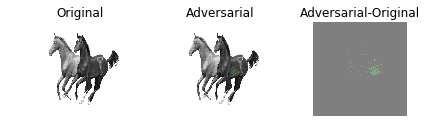

In [6]:
image=image.astype(np.uint8)
adv_img=adv_img.astype(np.uint8)
show_images_diff(image[0],0,adv_img[0],0)